# Comparison of Cech and Cover Filtrations

We need to construct both the Cech and Cover Filtrations in a way that allows us to compare them.

Computing the Cover filtration from a set of balls will be hard. To work around this, we could estimate it by heavily sampling the domain, computing cech on a small subset of points, then comparing the intersection. This is reminicent of Monte Carlo sampling.

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np

import dionysus as dio
from ripser import Rips
from persim import plot_diagrams

# from cechmate import Cover
import cechmate
# from paths import jaccard

# In R^2

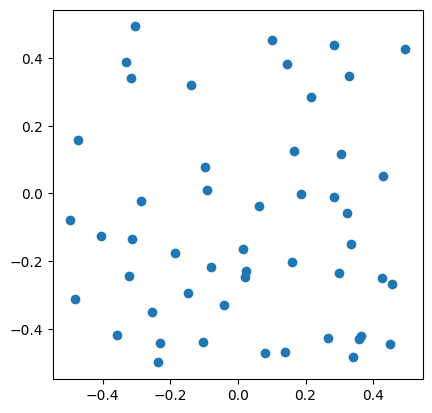

In [4]:
# 50 random points in R^2 in unit cube centered at 0 

landmarks = np.random.random((50, 2)) - 0.5
plt.scatter(landmarks[:,0], landmarks[:,1])
plt.axis('square')
plt.show()

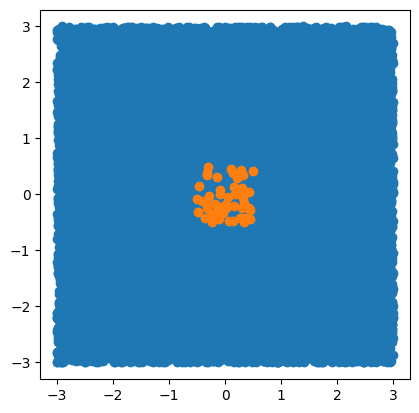

In [5]:
# Sample tons of points but in larger area

montemarks = 6*np.random.random((20000, 2))-3
plt.scatter(montemarks[:,0], montemarks[:,1])
plt.scatter(landmarks[:,0], landmarks[:,1])
plt.axis('square')
plt.show()

# Compute Rips filtration

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
13


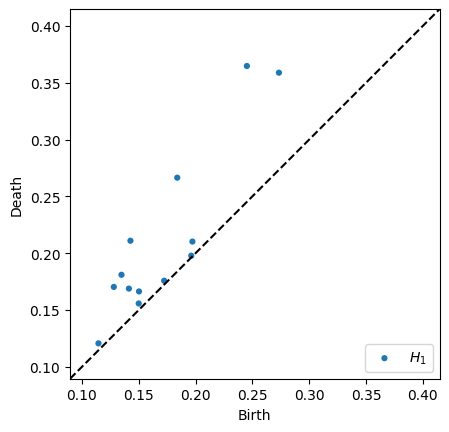

In [6]:
r = Rips(maxdim=2)
dgms = r.fit_transform(landmarks)[1]
print(len(dgms))
r.plot(dgms, labels=["$H_1$"])

# Compute Cover Cech Filtration

- Use dionysus to build up filtration
- Only compute up to triangles
- Look at all pairwise and 3way intersections
- Compute all points in each of 3 balls, use set intersections to find nonempty.

In [7]:
r = 2. # plenty big

# For each point, get enumeration. Get combinations of len 2 of the enumeration, then len 3.
# Get indices of points in the balls, compute intersection and union of indices.
# If value (which there should be), add the edge or triangle to the filtration with that value.
# Compute persistence.

lns = list(enumerate(landmarks))
possible_edges = combinations(lns, 2)
possible_triangles = combinations(lns, 3)

filtration = [((i,), 0.0) for i, l in lns]

def idx_points_in_ball(center, r, points):
    return np.where(np.linalg.norm(center - points, axis=1) < r)[0]

# start idx, start point, end idx, end point
for (si, sp), (ei, ep) in possible_edges:
    spb = set(idx_points_in_ball(sp, r, montemarks))
    epb = set(idx_points_in_ball(ep, r, montemarks))
    
    d = 1 - len(spb.intersection(epb)) / len(spb.union(epb))
    filtration.append( ((si, ei), d) )
    
# start idx, start point, middle idx, middle point, end idx, end point (yes triangles dont have middles and ends)
for (si, sp), (mi, mp), (ei, ep) in possible_triangles:
    spb = set(idx_points_in_ball(sp, r, montemarks))
    mpb = set(idx_points_in_ball(mp, r, montemarks))
    epb = set(idx_points_in_ball(ep, r, montemarks))
    
    d = 1- len(spb.intersection(mpb).intersection(epb)) / len(spb.union(mpb).union(epb))
    filtration.append( ((si, mi, ei), d) )

dgms_vcech = cechmate.solver.phat_diagrams(filtration)
# dgms_vcech = jaccard.compute_diagrams(filtration)[1]

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.15)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.0437)


# Compute Cover Rips Equivalent

In [8]:
r = 2.0 # plenty big

lns = list(enumerate(landmarks))
possible_edges = combinations(lns, 2)

filtration = [((i,), 0.0) for i, l in lns]

def idx_points_in_ball(center, r, points):
    return np.where(np.linalg.norm(center - points, axis=1) < r)[0]

edges = []
# start idx, start point, end idx, end point
for (si, sp), (ei, ep) in possible_edges:
    spb = set(idx_points_in_ball(sp, r, montemarks))
    epb = set(idx_points_in_ball(ep, r, montemarks))
    
    d = 1 - len(spb.intersection(epb)) / len(spb.union(epb))
    filtration.append( ((si, ei), d) )
    edges.append( ((si, ei), d) )

triangles = []
for e1, e2, e3 in combinations(edges, 3):
    (se1, ee1), d1 = e1
    (se2, ee2), d2 = e2
    (se3, ee3), d3 = e3
    
    vs = set(sorted([se1, ee1, se2, ee2, se3, ee3]))
    if len(vs) == 3:
        triangles.append((list(vs), max(d1, d2, d3)))
        filtration.append((list(vs), max(d1, d2, d3)))

        
dgms_vrips = cechmate.solver.phat_diagrams(filtration)
# print(f"Filtration has {len(filtration)} simplices")
# dgms_vrips = jaccard.compute_diagrams(filtration)[1]

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.086)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.0258)


# Compute Rips Filtration

In [24]:
f = dio.fill_rips(landmarks, 2, 1)
bm = dio.homology_persistence(f)
dg = dio.init_diagrams(bm, f)
dg = [np.array([[pt.birth, pt.death] for pt in diagram]) for diagram in dg]

# Compare Cover and Rips

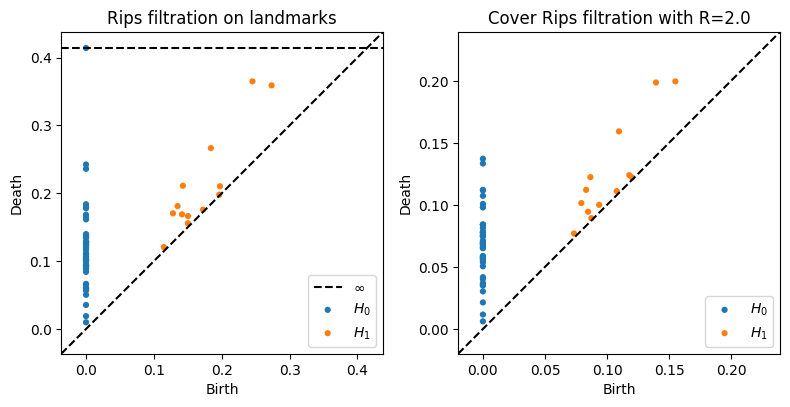

In [27]:

plt.figure(figsize=(8,4))
#plt.title("Rips filtration on landmarks")
plot_diagrams(dg, plot_only=[0,1], ax=plt.subplot(121), title="Rips filtration on landmarks")
# plot_dgms(dg, labels="$H_1$")
# plt.axis("square")

#plt.title(f"Cover Rips filtration with R={r}")
plot_diagrams(dgms_vrips, ax=plt.subplot(122), title=f"Cover Rips filtration with R={r}")
#plot_dgms(dgms_vrips[1], labels=["$H_1$"])
# plt.axis("square")

plt.tight_layout()
plt.savefig("comparison_of_filtrations.png")
plt.show()

In [28]:
def relationship(c, R):
    """ Compute the Verinice weight given the Cech weight and the big R:
    
    
                        R^2  - 2 (R^2 arccos(c/R) - c sqrt(R^2 - c^2))
        V(c, R) :=    --------------------------------------------------
                        R^2  -   (R^2 arccos(c/R) - c sqrt(R^2 - c^2))
    
    """
    
    A = R * R * np.arccos(c/R) - c * np.sqrt(R*R - c*c)
    B = np.pi * R * R
    
    return (B - 2*A) / (B - A)

In [30]:
[relationship(c, 2.0) for c in dg[1].flatten()]

[np.float64(0.13592263349358577),
 np.float64(0.14264872038048734),
 np.float64(0.15073295349956997),
 np.float64(0.19549435644890054),
 np.float64(0.15803128547755138),
 np.float64(0.2064480864887278),
 np.float64(0.1650376797327708),
 np.float64(0.19394811593031083),
 np.float64(0.16647376173037035),
 np.float64(0.23646382955287207),
 np.float64(0.1742198287980957),
 np.float64(0.18031105548650042),
 np.float64(0.17448132875449024),
 np.float64(0.19135491300157206),
 np.float64(0.19759905748551795),
 np.float64(0.2010994225180802),
 np.float64(0.20940090509496567),
 np.float64(0.289365394029572),
 np.float64(0.22180748052105542),
 np.float64(0.22340686363078832),
 np.float64(0.22285609211583662),
 np.float64(0.23573666832550358),
 np.float64(0.26947120743338504),
 np.float64(0.3752313614816226),
 np.float64(0.29572885447404496),
 np.float64(0.37033953760043314)]

# Comparison in 3D

In [31]:
import numpy as np
def jaccard3d(R,d):
    VI = (np.pi / 12) * (4*R + d)*(2*R - d)*(2*R - d)
    VU = (8*np.pi / 3)*R**3 - VI
    
    return 1 - (VI / VU)

def cech3d(d):
    return d / 2

ds = np.linspace(0.1, 10, 1000)
R = 100

js = jaccard3d(R, ds)
cs = cech3d(ds)

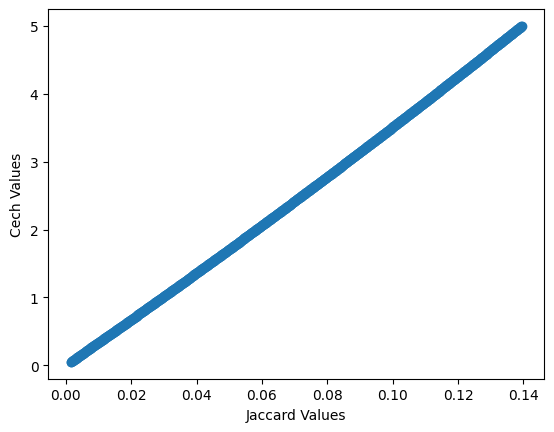

In [32]:
import matplotlib.pyplot as plt

plt.scatter(js, cs)
plt.xlabel("Jaccard Values")
plt.ylabel("Cech Values")
plt.show()